Importação de todas as bibliotecas utilizadas neste notebook

In [4]:
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.util import pad_sequence
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams
from nltk.lm import MLE
from nltk.lm import Laplace
from nltk.lm import KneserNeyInterpolated
from nltk.lm import WittenBellInterpolated
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import flatten
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.corpus import stopwords
import string
import itertools

nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Texto de treinamento extraídos com IA a partir de artigos de acesso aberto:

## training-paper2.txt:
Título: Remote Patient Monitoring via Non-Invasive Digital Technologies: A Systematic Review

Autores: Ashok Vegesna, PharmD Melody Tran, PharmD Michele Angelaccio and Steve Arcona, PhD

Link: https://www.liebertpub.com/doi/10.1089/tmj.2016.0051


In [37]:
import io
import requests

url = "https://raw.githubusercontent.com/siliciumtecnologia/Trabalho-DataScience/main/training-paper2.txt"
response = requests.get(url)
response.raise_for_status()

text = response.text


print(f"Tamanho do texto: {len(text)}")

Tamanho do text: 15156


Limpeza e tokenização do texto

In [38]:
# Separa em frases
sent_tokens = [list(map(str.lower, word_tokenize(sent)))
                  for sent in sent_tokenize(text)]

# Remove os 'simbolos de pontuação
filtered_word_tokens_from_sentences = [[word for word in sentence if word not in string.punctuation]
                                         for sentence in sent_tokens]

# Obtêm uma lista de palavras de parada parao inglês
stop_words = set(stopwords.words('english'))

# Remove as palavras de parada
filtered_word_tokens_from_sentences_and_stop_words = [[word for word in sentence if word not in stop_words]
                                         for sentence in filtered_word_tokens_from_sentences]

# Gera uma lista plana com os tokens de todas as frases
flattened_tokens = list(itertools.chain.from_iterable(filtered_word_tokens_from_sentences))

print(f"Número de tokens que serão utilizados para o treinamento: {len(flattened_tokens)}")

Número de tokens que serão utilizados para o treinamento: 2109


Gera uma lista com as palavras mais comuns

In [39]:
from collections import Counter
import itertools # Import itertools

# Gera uma lista plana dos tokens
flattened_word_tokens = list(itertools.chain.from_iterable(filtered_word_tokens_from_sentences_and_stop_words))

# Calcula a frequência de cada token no texto
word_frequency = Counter(flattened_word_tokens)

# Apresenta as 20 palavras mais comuns no texto
print("As palavras mais comuns e suas frequências:")
for word, frequency in word_frequency.most_common(20):
    print(f"{word}: {frequency}")

As palavras mais comuns e suas frequências:
studies: 41
patient: 30
included: 23
data: 23
rpm: 22
technologies: 21
digital: 19
study: 19
technology: 17
health: 17
noninvasive: 15
review: 13
systematic: 11
criteria: 11
outcomes: 11
used: 11
healthcare: 11
e.g.: 11
identified: 9
devices: 9


Exibe um gráfico com as 20 palavras mais comuns

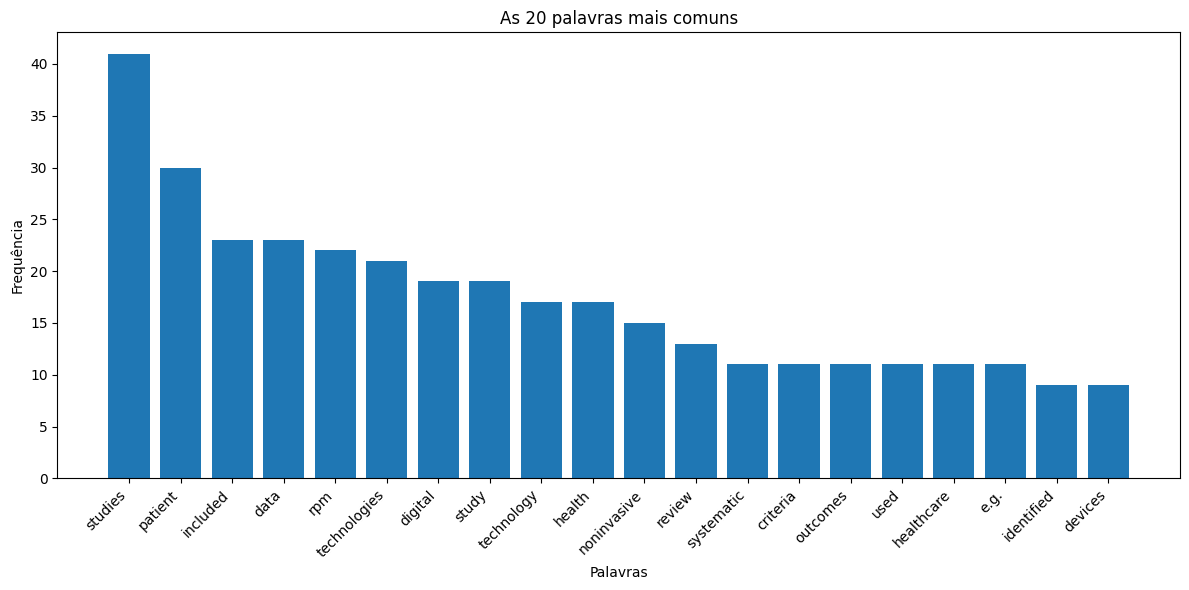

In [40]:
import matplotlib.pyplot as plt

# Obtêm as 20 palavras mais comuns e suas frequências
most_common_words = word_frequency.most_common(20)
words = [word for word, frequency in most_common_words]
frequencies = [frequency for word, frequency in most_common_words]

plt.figure(figsize=(12, 6))
plt.bar(words, frequencies)
plt.xlabel("Palavras")
plt.ylabel("Frequência")
plt.title("As 20 palavras mais comuns")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Para medir a dispersão, calcula-se a frequência relativa e a uniformidade da distribuição dessas palavras.

Uma abordagem simples é observar as palavras mais comuns mas que estão dispersas e também para palvras que são comus mas estão concentradas.

In [9]:
# Considera palavras que aparecem pelo menos um certo número de vezes para eliminar ruídos
min_frequency = 5

# Obt6em a lista de palvras que possuem essa frequência mínima
frequent_words = [word for word, frequency in word_frequency.items() if frequency >= min_frequency]

# para conseguir calcular a dispersão, observa-se a faixa de posição que elas se encontram no texto
# se essa faixa for ampla, sugere que a palavra está dispersa no texto


word_indices = {}
for i, word in enumerate(flattened_word_tokens):
    if word in frequent_words:
        if word not in word_indices:
            word_indices[word] = []
        word_indices[word].append(i)

# Faz o cálculo das faixas de posição para cada palavra
word_range = {word: max(indices) - min(indices) for word, indices in word_indices.items()}

# ordena conforme a faixa (descendente para as mais dispersas e ascendente para as mais concentradas). Obtêm as 5 mais de cada extremo
most_dispersed = sorted(word_range.items(), key=lambda item: item[1], reverse=True)[:5]
most_concentrated = sorted(word_range.items(), key=lambda item: item[1])[:5]


print("Palavras mais dispersas (pela distância):")
for word, range_value in most_dispersed:
    print(f"{word}: Distância = {range_value}")

print("\nPalavras mais conventradas (pela distância):")
for word, range_value in most_concentrated:
     print(f"{word}: Distância = {range_value}")

Palavras mais dispersas (pela distância):
technologies: Distância = 1407
patient: Distância = 1371
studies: Distância = 1362
used: Distância = 1360
conducted: Distância = 1348

Palavras mais conventradas (pela distância):
age: Distância = 30
device: Distância = 166
years: Distância = 201
casp: Distância = 213
primarily: Distância = 307


Exibe um gráfico com as 5 palavras mais dispersas

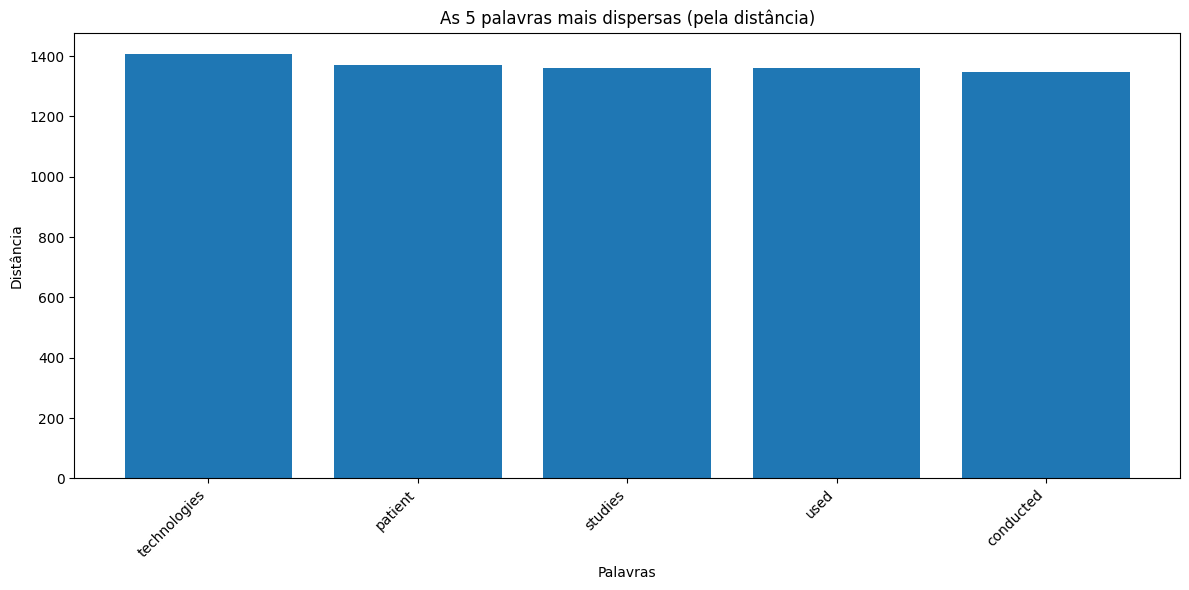

In [10]:
import matplotlib.pyplot as plt

words_dispersed = [word for word, range_value in most_dispersed]
ranges_dispersed = [range_value for word, range_value in most_dispersed]

plt.figure(figsize=(12, 6))
plt.bar(words_dispersed, ranges_dispersed)
plt.xlabel("Palavras")
plt.ylabel("Distância")
plt.title("As 5 palavras mais dispersas (pela distância)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Gera um gráfico com as 5 palavras mais concentradas

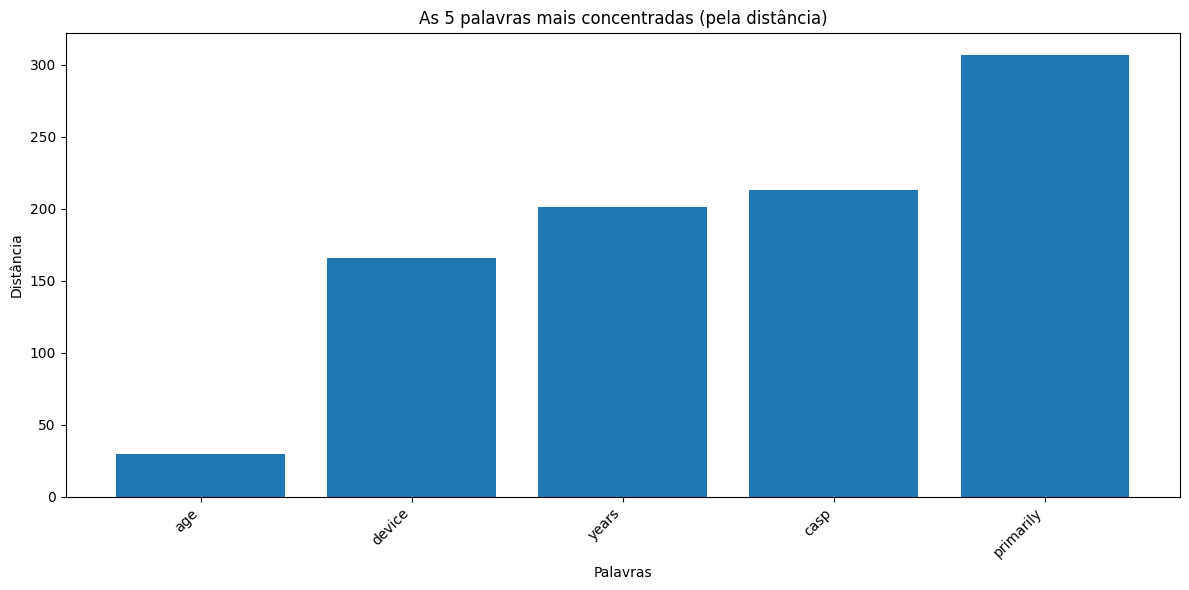

In [11]:
import matplotlib.pyplot as plt

words_concentrated = [word for word, range_value in most_concentrated]
ranges_concentrated = [range_value for word, range_value in most_concentrated]

plt.figure(figsize=(12, 6))
plt.bar(words_concentrated, ranges_concentrated)
plt.xlabel("Palavras")
plt.ylabel("Distância")
plt.title("As 5 palavras mais concentradas (pela distância)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Mostra o gráfico de dispersão para as palavras mais dispersas

<Figure size 1200x600 with 0 Axes>

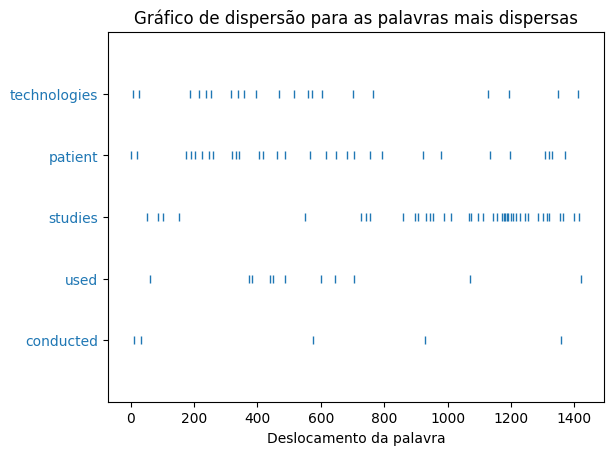

In [12]:
import nltk
import matplotlib.pyplot as plt

words_dispersed = [word for word, range_value in most_dispersed]

plt.figure(figsize=(12, 6))
text_nltk = nltk.Text(flattened_word_tokens)
text_nltk.dispersion_plot(words_dispersed)
plt.title("Gráfico de dispersão para as palavras mais dispersas")
plt.xlabel("Deslocamento da palavra")
plt.show()

Mostra um gráfico de dispersão para as palavras mais concentradas

<Figure size 1200x600 with 0 Axes>

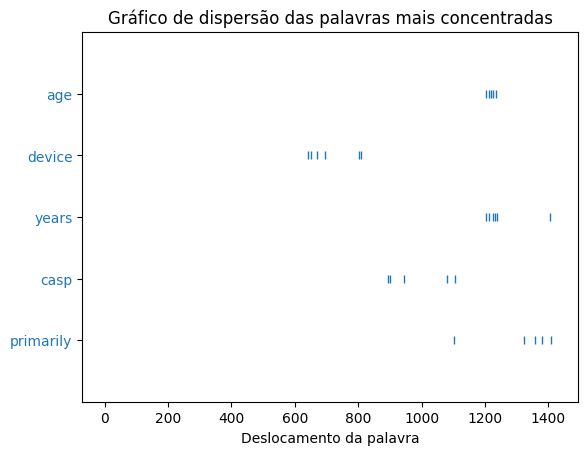

In [13]:
import nltk
import matplotlib.pyplot as plt

# Get the most concentrated words
words_concentrated = [word for word, range_value in most_concentrated]

# Create a dispersion plot for the most concentrated words
plt.figure(figsize=(12, 6))
text_nltk = nltk.Text(flattened_word_tokens) # Create an NLTK Text object
text_nltk.dispersion_plot(words_concentrated)
plt.title("Gráfico de dispersão das palavras mais concentradas")
plt.xlabel("Deslocamento da palavra")
plt.show()

Essa função faz o cálculo da perplexidade de uma determinada frase para um modelo

In [14]:
import nltk
from nltk.lm.preprocessing import pad_both_ends
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import string

def calculate_sentence_perplexity(model, sentence, n):
  """
  Calcula a perplexidade de uma única frase usando um modelo treinado.

  Args:
    model: O modelo treinado.
    sentence: A frase de entrada (string).
    n: O tamanho do n-grama utilizado para treinar o modelo.

  Returns:
    A perplexidade da frase, ou None se ocorrer um erro.
  """
  # Preprocessa a frase: tokenize, coloca em letras minúsculas, retira a pontuação e as palavras de parada
  stop_words = set(stopwords.words('english'))
  sentence_tokens = word_tokenize(sentence.lower())
  filtered_tokens = [word for word in sentence_tokens if word not in string.punctuation and word not in stop_words]
  padded_sentence = list(pad_both_ends(filtered_tokens, n=n))

  # Converte para n-gramas
  sentence_ngrams = list(ngrams(padded_sentence, n=n))

  try:
    # Calcula a perplexidade
    perplexity = model.perplexity(sentence_ngrams)
    return perplexity
  except Exception as e:
    print(f"Error calculating perplexity: {e}")
    return None



Essa função gera um texto com base em uma semente para o modelo indicado

In [32]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

detokenize = TreebankWordDetokenizer().detokenize

def generate_text_with_seed(model, seed_sentence, num_words=50):
  """
  Gera texto com uma determinada semente usando um modelo treinado.
  Generates text using a trained language model, seeded with a sentence.

  Args:
    model: O modelo treinado.
    seed_sentence: A frase de entrada (string).
    num_words: O número máximo de palavras a serem geradas.


  Returns:
    A string contendo a semente e o texto gerado.
  """

  # Faz a geração passando a string como parâmetro. O modelo faz o tratamento da string
  generated_sequence = model.generate(num_words, text_seed=seed_sentence, random_seed=153)

  # Faz a conversão da sequência gerada para um lista de strings. Os terminadores precisam
  # ser removidos da frase final, e o terminar de fim de frase é substituído por um ponto final
  # e a frase é encerrada neste token
  content = []
  for token in generated_sequence:
      if token == '<s>':
          continue
      elif token == '</s>':
          content.append('.')
          break
      else:
          content.append(token)


  # Monta uma string com os tokens gerados
  generated_text = detokenize(content)

  return seed_sentence + " " + generated_text

Constrói 4 modelos em 4 variações de n-grama, gera uma frase e calcula sua perplexidade

In [41]:
from nltk.lm import MLE, Laplace, KneserNeyInterpolated, WittenBellInterpolated, Lidstone, AbsoluteDiscountingInterpolated
from nltk.lm.preprocessing import padded_everygram_pipeline

results = {}

# Testa com 4 n-gramas
n_values = [2, 3, 4, 5]

for n in n_values:
    print(f"\nProcessando modelos para {n}-grama")
    results[n] = {} # lista com o resultado final


    for model_type in [Laplace, AbsoluteDiscountingInterpolated, WittenBellInterpolated, KneserNeyInterpolated]:

        print(f" Modelo: {model_type.__name__}")

        # Recria os dados, pois cada treinamento altera esses objetos
        train_data, padded_sents = padded_everygram_pipeline(n, filtered_word_tokens_from_sentences)
        # Cria o modelo
        model = model_type(n)

        # Treina o modelo
        model.fit(train_data, padded_sents)

        print(f" Vocabulário: {len(model.vocab)}")

        # Faz a geração usando uma semente específica, até 20 palavras
        seed = "common clinical data captured by these technologies"
        generated_output = generate_text_with_seed(model, seed, 20)
        print(f" Texto gerado:{generated_output}")

        sentence_perplexity = calculate_sentence_perplexity(model, generated_output, n)

        print(f" Perplexidade do texto gerado: {sentence_perplexity}")

        results[n][model_type.__name__] = {
            'generated_sentence': generated_output,
            'perplexity': sentence_perplexity
        }
        print("\n")

print("\nConcluído")


Processando modelos para 2-grama
 Modelo: Laplace
 Vocabulário: 684
 Texto gerado:common clinical data captured by these technologies was conducted by these variances this study variables including the search terms of studies were randomized controlled trials rcts cohort
 Perplexidade do texto gerado: 446.6582079315395


 Modelo: AbsoluteDiscountingInterpolated
 Vocabulário: 684
 Texto gerado:common clinical data captured by these technologies was conducted by the systematic review of the trustworthiness and systematic review noted the systematic review used to determine whether
 Perplexidade do texto gerado: 57.562752408412116


 Modelo: WittenBellInterpolated
 Vocabulário: 684
 Texto gerado:common clinical data captured by these technologies was conducted by these variances this study validity bias study validity bias study selection process utilized wearable devices.
 Perplexidade do texto gerado: 18.618300327760952


 Modelo: KneserNeyInterpolated
 Vocabulário: 684
 Texto gerado:c

Plata gráficos com as perplexidades dos textos gerados pelos vários modelos

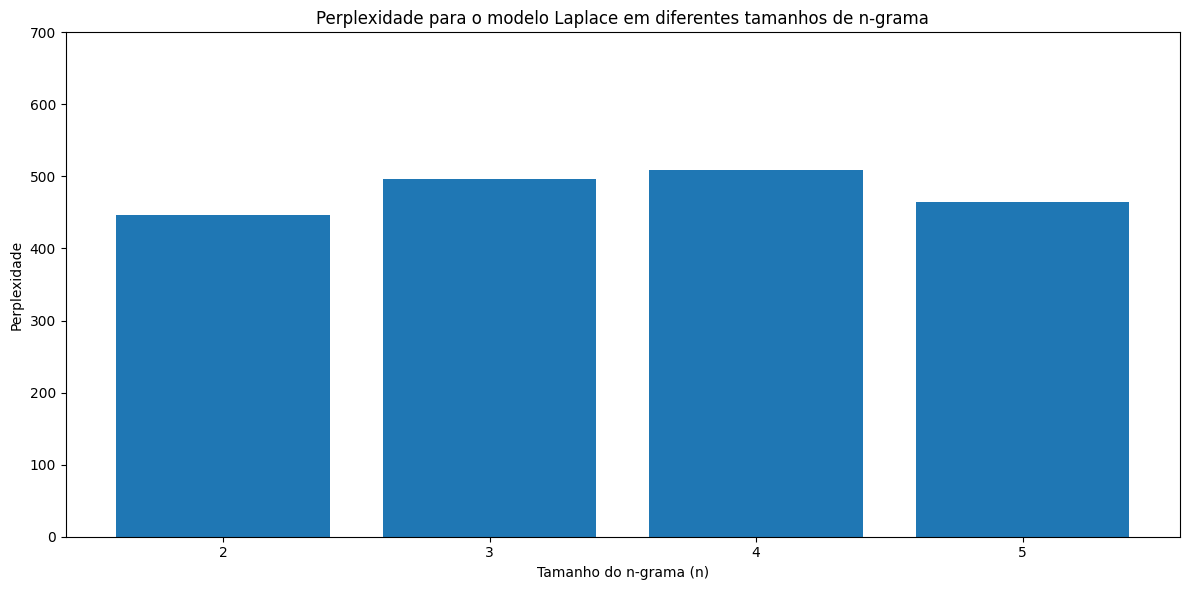

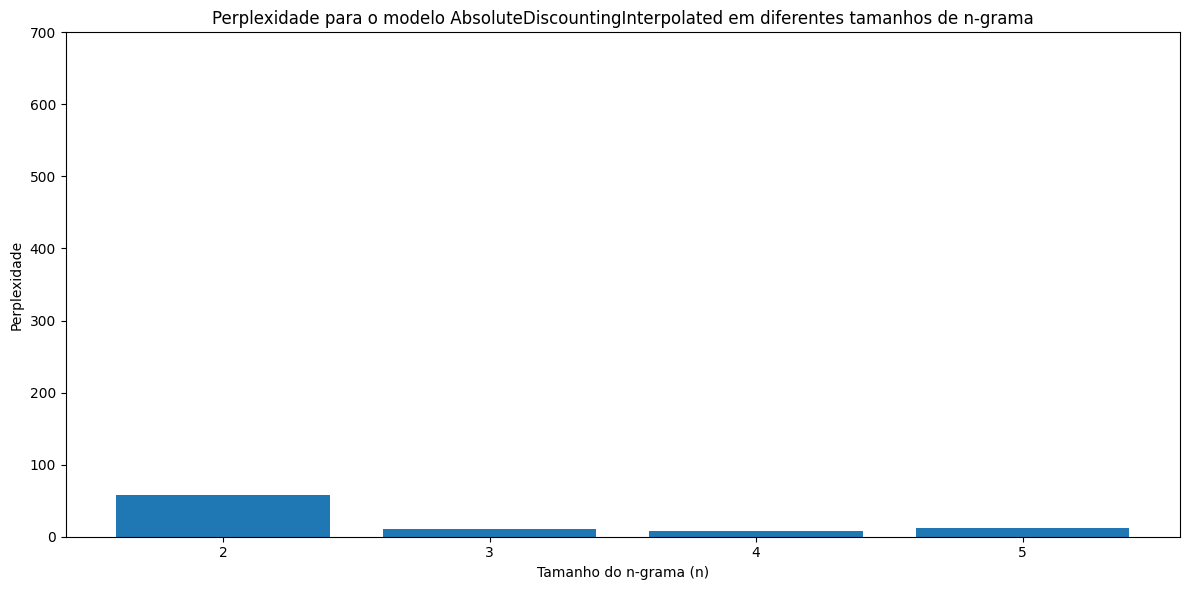

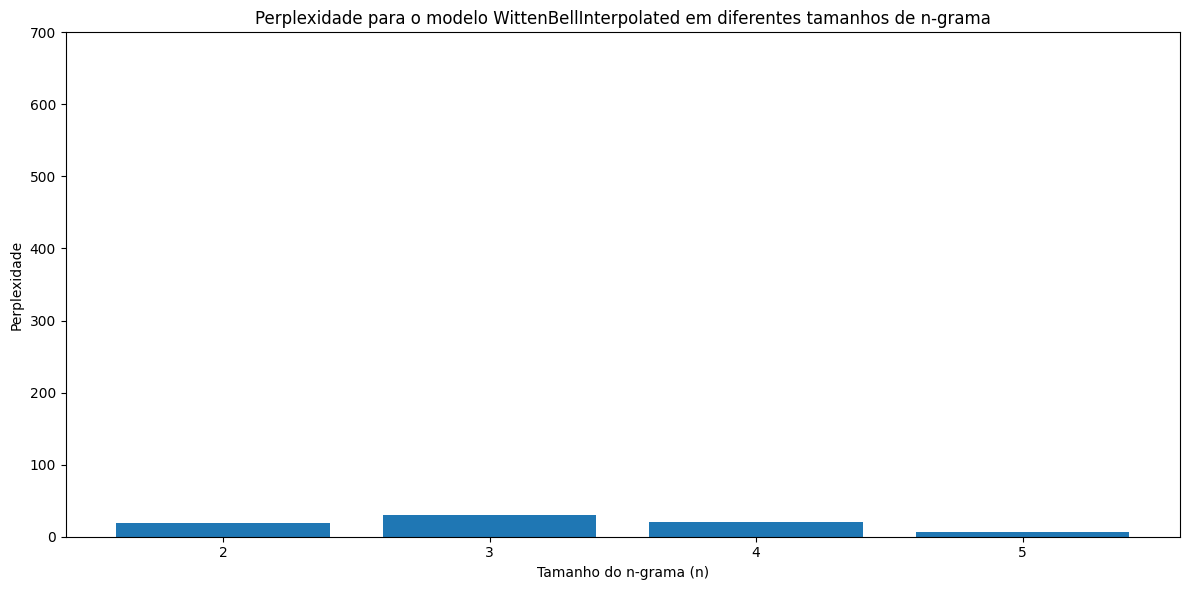

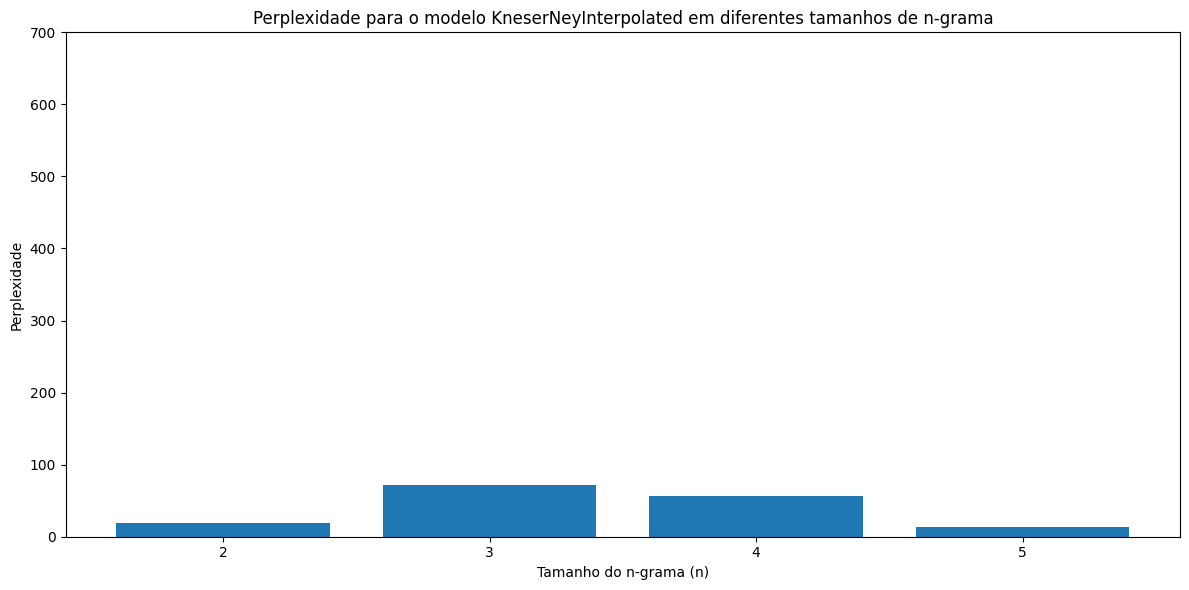

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Reorganiza o resultado para agrupar por tipo de modelo
model_results = {}
for n, n_results in results.items():
    for model_name, model_data in n_results.items():
        if model_name not in model_results:
            model_results[model_name] = {'n_values': [], 'perplexity_scores': []}
        model_results[model_name]['n_values'].append(n)
        model_results[model_name]['perplexity_scores'].append(model_data['perplexity'])


for model_name, data in model_results.items():
    n_values = data['n_values']
    perplexity_scores = data['perplexity_scores']

    # A perplexidade poderá retornar +Inf em algumas situações, então substitui por um valor bem grande
    # para evitar erros nas funções do matplotlib
    perplexity_scores = [score if np.isfinite(score) else 10000 for score in perplexity_scores]

    plt.figure(figsize=(12, 6))
    plt.bar(np.arange(len(n_values)), perplexity_scores)
    plt.xticks(np.arange(len(n_values)), n_values)
    plt.xlabel("Tamanho do n-grama (n)")
    plt.ylabel("Perplexidade")
    plt.title(f"Perplexidade para o modelo {model_name} em diferentes tamanhos de n-grama")
    plt.ylim(0, 700) # Set fixed y-axis limit
    plt.tight_layout()
    plt.show()